<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/reviews/analise_exploratoria_2018%2Bfiltrado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurando ambiente

monta o google drive e define paleta de cores para o seaborn utilizar

In [301]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

from google.colab import drive
sns.color_palette("tab10")
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


autentica o usuario no google para poder utilizar o google sheets

In [302]:
from google.colab import auth
import gspread
from google.auth import default

auth.authenticate_user()

creds, _ = default()

gc = gspread.authorize(creds)

faz o download de stopwords e punkt do nltk

In [303]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Baixe a lista de stopwords em português
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Dados dos hoteis

definindo a data dos arquivos que serão utilizados

In [304]:
date = "2023/07/07"

## Cria o DataFrame

carregamos então o google sheets onde está definida a lista de hotéis em um dataframe pandas e validamos a existencia do sns

In [305]:
ws = gc.open('PGC-hotels')
emerson = ws.worksheet('Emerson')
hotels = pd.DataFrame(emerson.get_all_records())[['name', 'stars', 'overall_rating', 'region', 'state', 'qtd_reviews', 'source']]

sns.__version__

'0.12.2'

### carregando um unico arquivo

In [306]:
filename = 'grand-oca-maragogi-gm-reviews.csv'
dados = pd.read_csv(f"/content/gdrive/MyDrive/tcc/data/{date}/{filename}")
dados['source'] = filename.split('.')[0]
dados.loc[1]['text']

'De tudo do Resort um serviço superou as minhas expectativas: a Yasmin é uma manicure sensacional, fez muitíssimo bem meu pé e minha mão, nota mil'

### carregando todos os arquivos da pasta do google drive

In [307]:
import glob
import os

path_to_lookup = f'/content/gdrive/MyDrive/tcc/data/{date}/'
file_pattern = "*.csv"

# setting the path for joining multiple files
files = os.path.join(path_to_lookup, file_pattern)

# list of merged files returned
files = glob.glob(files)

dados = pd.concat(map(lambda file: pd.read_csv(file).assign(source=file.split("/")[-1].split('-gm-reviews')[0]), files), ignore_index=True)

In [308]:
df = dados[['retrieval_date', 'rating', 'relative_date', 'likes', 'user_is_local_guide', 'text', 'source', 'user_reviews']].copy()

### Tratando dataset

#### preparando colunas

Transformamos a data relativa da realização do review em datetime e criamos novas colunas com partes dessa data e também quantidade de reviews de um usuario em um valor inteiro.

##### definindo transformações

In [309]:
from datetime import datetime, timedelta
import re

def transform_user_reviews(x):
  if isinstance(x, str) and x == 'Um':
    1
  elif isinstance(x, str):
    return int(x.replace('.',''))
  return x

def from_relative_date_to_timestamp(row):
  # String de data relativa
  data_relativa_str = row.relative_date
  timestamp = row.retrieval_date

  # Converte a string em um objeto timedelta
  unidade_tempo = data_relativa_str.split()[1]
  quantidade_tempo = 1 if 'um' in data_relativa_str.split()[0] else int(data_relativa_str.split()[0])

  if 'segundo' in unidade_tempo:
      data_relativa = timedelta(seconds=quantidade_tempo)
  elif 'minuto' in unidade_tempo:
      data_relativa = timedelta(minutes=quantidade_tempo)
  elif 'hora' in unidade_tempo:
      data_relativa = timedelta(hours=quantidade_tempo)
  elif 'dia' in unidade_tempo:
      data_relativa = timedelta(days=quantidade_tempo)
  elif 'semana' in unidade_tempo:
      data_relativa = timedelta(weeks=quantidade_tempo)
  elif re.match(r"m(ê|e)s", unidade_tempo):
      data_relativa = timedelta(days=30*quantidade_tempo)
  elif 'ano' in unidade_tempo:
      data_relativa = timedelta(days=365*quantidade_tempo)
  else:
      return timestamp

  # Timestamp parse
  try:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
  except:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')

  return (dt_timestamp - data_relativa).date()

##### transformações rápidas

In [310]:
df['user_reviews'] = df['user_reviews'].apply(transform_user_reviews).fillna(0) ## número de reviews do autor do review atual

df['data_avaliacao'] = pd.to_datetime(df.apply(from_relative_date_to_timestamp, axis=1)) ## data da avaliação

# Extract month and year from the 'date' column
df['mes_avaliacao'] = df['data_avaliacao'].dt.month
df['ano_avaliacao'] = df['data_avaliacao'].dt.year

# Create a new column representing the combination of month and year
df['mes_ano_avaliacao'] = df['data_avaliacao'].dt.to_period('M')

##### contagem de avaliações por ano sem filtros

In [311]:
df.ano_avaliacao.value_counts()[df.ano_avaliacao.unique()]

2023    11925
2022    16364
2021     8104
2020    12489
2019    18963
2018    12625
2017     4426
2016      940
2015      247
2014      106
2013       88
2012        9
2011        5
Name: ano_avaliacao, dtype: int64

##### Marcação de avaliações

Marcando avaliações que:

*   Possuem algum caractere
*   Possuem três ou mais caracteres
*   Foram realizados depois de 2017
*   Foram traduzidos pelo google

In [312]:
df['com_texto'] = df['text'].str.len() > 2
df['nao_vazio'] = df['text'].notna()
df['traduzido'] = df['text'].str.contains('Tradução do Google', na=False)
df['depois_2017'] = df['ano_avaliacao'] > 2017

##### marcando avaliações que serão analisados

Então marcamos as avaliações de interesse, isto é as que iremos utilizar na analise, considerando os seguintes filtros:
*   Reviews que foram públicados após 2017
*   Não foram traduzidos pelo google
*   E possuem mais de 2 caracteres no seu conteudo


É esperado que a avaliação possua algum texto para que possa ser possivel detectar o seu sentimento por esse motivo escolhemos as que possuem mais de 2 caracteres em sua composição. Estamos também interessados em avaliações realizadas no idioma português e por este motivo filtramos também as que foram traduzidas pelo google.

In [313]:
df['analisar'] = (df['com_texto']) & (~df['traduzido']) & (df['depois_2017'])
analisar_df = df[df['analisar']].copy()

distribuição por ano da quantidade de avaliações que atendem o filtro utilizado

In [314]:
analisar_df.ano_avaliacao.value_counts()[analisar_df.ano_avaliacao.unique()]

2023     9444
2022    11866
2021     5350
2020     6236
2019     9645
2018     6678
Name: ano_avaliacao, dtype: int64

Tendo a lista de hotéis e a lista de avaliações, mesclamos ambas para poder gerar informações e poder realizar analises temporais de cada hotel e região de forma independente

In [315]:
import unicodedata

hotels['source_normalized'] = hotels['source'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))
df['source_normalized'] = df['source'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))

hotels_metadados = pd.merge(hotels, df, on="source_normalized")[['name', 'stars', 'overall_rating', 'region', 'state', 'analisar']]

In [316]:
hotels_reviews = hotels_metadados.groupby(['name', 'state', 'stars', 'overall_rating', 'analisar']).agg(counts=('analisar', 'size'))
hotels_reviews['total_counts'] = hotels_reviews.groupby('name')['counts'].transform('sum')

hotels_reviews['percentage'] = hotels_reviews['counts'] / hotels_reviews['total_counts'] * 100

#### quantidade de avaliações

##### quantidade total de avaliações

In [317]:
df.shape[0] ## avaliações no total com e sem texto

86291

##### quantidade de avaliações que serão analisados

In [318]:
analisar_count = sum(df['analisar'])
analisar_perc = analisar_count / df.shape[0]

##### quantidade de reviews traduzidos ou com menos de 3 caracteres (2 ou menos)

In [319]:
n_analisar_count = sum(~df['analisar'])
n_analisar_perc = n_analisar_count / df.shape[0]

##### quantidade de reviews traduzidos e sem texto

In [320]:
traduzido_count = sum(df['traduzido'])
traduzido_perc = traduzido_count / df.shape[0] ## reviews traduzidos

In [321]:
com_texto_count = sum(df['com_texto'])
com_texto_perc = com_texto_count / df.shape[0] ## reviews traduzidos

In [322]:
depois_2017_count = sum(df['depois_2017'])
depois_2017_perc = depois_2017_count / df.shape[0] ## reviews traduzidos
antes_2017_count = sum(~df['depois_2017'])
antes_2017_perc = antes_2017_count / df.shape[0] ## reviews traduzidos

In [323]:
vazio_count = sum(~df['nao_vazio'])
vazio_perc = vazio_count / df.shape[0] ## reviews traduzidos
menos_2_carc_count = df.shape[0] - vazio_count - com_texto_count
menos_2_carc_perc = menos_2_carc_count / df.shape[0] ## reviews traduzidos

valores:

In [324]:
print(f'''Considerando todas as avaliações obtidas, temos:
\t1. {depois_2017_count}({depois_2017_perc:.2%}) enviadas depois de 2017 e {antes_2017_count}({antes_2017_perc:.2%}) enviadas em 2017 ou antes
\t2. {com_texto_count}({com_texto_perc:.2%}) com texto e 3 ou mais caracteres, {vazio_count}({vazio_perc:.2%}) sem texto e {menos_2_carc_count}({menos_2_carc_perc:.2%}) avaliações com 1 ou 2 caracteres
\t3. {traduzido_count}({traduzido_perc:.2%}) avaliações traduzidas'''
)

Considerando todas as avaliações obtidas, temos: 
	1. 80470(93.25%) enviadas depois de 2017 e 5821(6.75%) enviadas em 2017 ou antes
	2. 56893(65.93%) com texto e 3 ou mais caracteres, 29386(34.05%) sem texto e 12(0.01%) avaliações com 1 ou 2 caracteres
	3. 4184(4.85%) avaliações traduzidas


In [325]:
 print(f'E dentre todas as avaliações obtidas utilizaremos para a analise o total de {analisar_count}({analisar_perc:.2%}) e {n_analisar_count}({n_analisar_perc:.2%}) foram ignoradas')

E dentre todas as avaliações obtidas utilizaremos para a analise o total de 49219(57.04%) e 37072(42.96%) foram ignoradas


#### exemplo

In [326]:
df.head()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar,source_normalized
0,2023-07-07 00:33:49.026816,5.0,7 horas atrás,-1,True,NaN,hotel-marsol-beach-resort,17,2023-07-06,7,2023,2023-07,False,False,False,True,False,hotel-marsol-beach-resort
1,2023-07-07 00:33:49.066269,5.0,10 horas atrás,-1,False,NaN,hotel-marsol-beach-resort,Um,2023-07-06,7,2023,2023-07,False,False,False,True,False,hotel-marsol-beach-resort
2,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,9,2023-07-06,7,2023,2023-07,True,True,False,True,True,hotel-marsol-beach-resort
3,2023-07-07 00:33:49.126736,5.0,10 horas atrás,0,False,(Tradução do Google) Ele disse (Original) Exel...,hotel-marsol-beach-resort,2,2023-07-06,7,2023,2023-07,True,True,True,True,False,hotel-marsol-beach-resort
4,2023-07-07 00:33:49.155893,5.0,10 horas atrás,-1,NaN,NaN,hotel-marsol-beach-resort,0,2023-07-06,7,2023,2023-07,False,False,False,True,False,hotel-marsol-beach-resort


In [327]:
hotels_reviews

counts  \
name                                         state stars overall_rating analisar           
Cana Brava All Inclusive Resort              BA    4     4.6            False       3028   
                                                                        True        8119   
Grand Oca Maragogi                           AL    5     4.3            False       2427   
                                                                        True        2210   
Hotel Marsol Beach Resort                    RN    4     4.2            False       1470   
                                                                        True        1863   
Hotel Vila Galé - Touros                     RN    5     4.6            False       1433   
                                                                        True        4369   
Hotel Vila Galé Marés                        BA    5     4.5            False       3550   
                                                                        True        5033   
Hotel Vila Galé: Eco Resort - Cabo           PE    5     4.5            False       2645   
                                                                        True        2746   
Iberostar Bahia                              BA    5     4.7            False       7830   
                                                                        True        8383   
La Torre Resort All Inclusive                BA    4     4.7            False       3164   
                                                                        True        3060   
Makai Resort Aracaju - All Inclusive         SE    4     4.3            False       2448   
                                                                        True        2846   
Nauticomar Resort All Inclusive & Beach Club BA    4     4.3            False       2104   
                                                                        True        2187   
Salinas Maceió All Inclusive Resort          AL    4     4.7            False       2140   
                                                                        True        2541   
Salinas Maragogi All Inclusive Resort        AL    5     4.8            False       3539   
                                                                        True        3917   
Transamerica Comandatuba                     BA    4     4.8            False       1294   
                                                                        True        1945   

                                                                                  total_counts  \
name                                         state stars overall_rating analisar                 
Cana Brava All Inclusive Resort              BA    4     4.6            False            11147   
                                                                        True             11147   
Grand Oca Maragogi                           AL    5     4.3            False             4637   
                                                                        True              4637   
Hotel Marsol Beach Resort                    RN    4     4.2            False             3333   
                                                                        True              3333   
Hotel Vila Galé - Touros                     RN    5     4.6            False             5802   
                                                                        True              5802   
Hotel Vila Galé Marés                        BA    5     4.5            False             8583   
                                                                        True              8583   
Hotel Vila Galé: Eco Resort - Cabo           PE    5     4.5            False             5391   
                                                                        True              5391   
Iberostar Bahia                              BA    5     4.7            False            16213   
                                   

### analise exploratoria

considerando todas as avaliações, então temos as seguintes metricas:


In [328]:
df.describe()

,rating,likes,mes_avaliacao,ano_avaliacao
count,86291.000000,86291.000000,86291.000000,86291.000000
mean,4.600630,-0.227880,6.849208,2020.147779
std,0.864428,0.804257,1.333079,1.921575
min,1.000000,-1.000000,1.000000,2011.000000
25%,5.000000,-1.000000,7.000000,2019.000000
50%,5.000000,0.000000,7.000000,2020.000000
75%,5.000000,0.000000,7.000000,2022.000000
max,5.000000,25.000000,12.000000,2023.000000


agora agrupando por hoteis avaliados, considerando avaliações com algum caractere de texto(não vazias), com mais de 2 caracteres, traduzidas pelo google e registradas após 2017.

In [329]:
df.groupby('source').agg(nao_vazio=('nao_vazio', 'sum'),
                         com_texto=('com_texto', 'sum'),
                         traduzido=('traduzido', 'sum'),
                         depois_2017=('depois_2017', 'sum'))

,nao_vazio,com_texto,traduzido,depois_2017
source,,,,
cana-brava-all-inclusive-resort,8583,8581,141,10656
grand-oca-maragogi,2948,2947,542,4297
hotel-marsol-beach-resort,2150,2150,162,3128
hotel-vila-galé---touros,4481,4480,111,5802
hotel-vila-galé-marés,5723,5721,315,7981
hotel-vila-galé:-eco-resort---cabo,3219,3217,183,4934
iberostar-bahia,10587,10586,1464,14848
la-torre-resort-all-inclusive,3847,3847,496,5722
makai-resort-aracaju---all-inclusive,3180,3180,84,4917


Agora a visualização sepando as avaliações que foram utilizadas na analise e as que não foram considerando informações de estrelas dos hotéis, quantidade de avaliações e classificação da avaliação concedida no momento do registro, temos:

In [330]:
valores = hotels_metadados.groupby(['state', 'analisar']).agg({'analisar': [ 'count' ],
                                                               'overall_rating': [ 'mean', 'min', 'max' ],
                                                               'stars': [ 'mean' ]})
valores

analisar overall_rating               stars
                  count           mean  min  max      mean
state analisar                                            
AL    False        8106       4.623896  4.3  4.8  4.735998
      True         8668       4.643205  4.3  4.8  4.706853
BA    False       20970       4.617740  4.3  4.8  4.542680
      True        28727       4.613016  4.3  4.8  4.467017
PE    False        2645       4.500000  4.5  4.5  5.000000
      True         2746       4.500000  4.5  4.5  5.000000
RN    False        2903       4.397451  4.2  4.6  4.493627
      True         6232       4.480424  4.2  4.6  4.701059
SE    False        2448       4.300000  4.3  4.3  4.000000
      True         2846       4.300000  4.3  4.3  4.000000

Similar ao conteúdo acima, porém mais visual

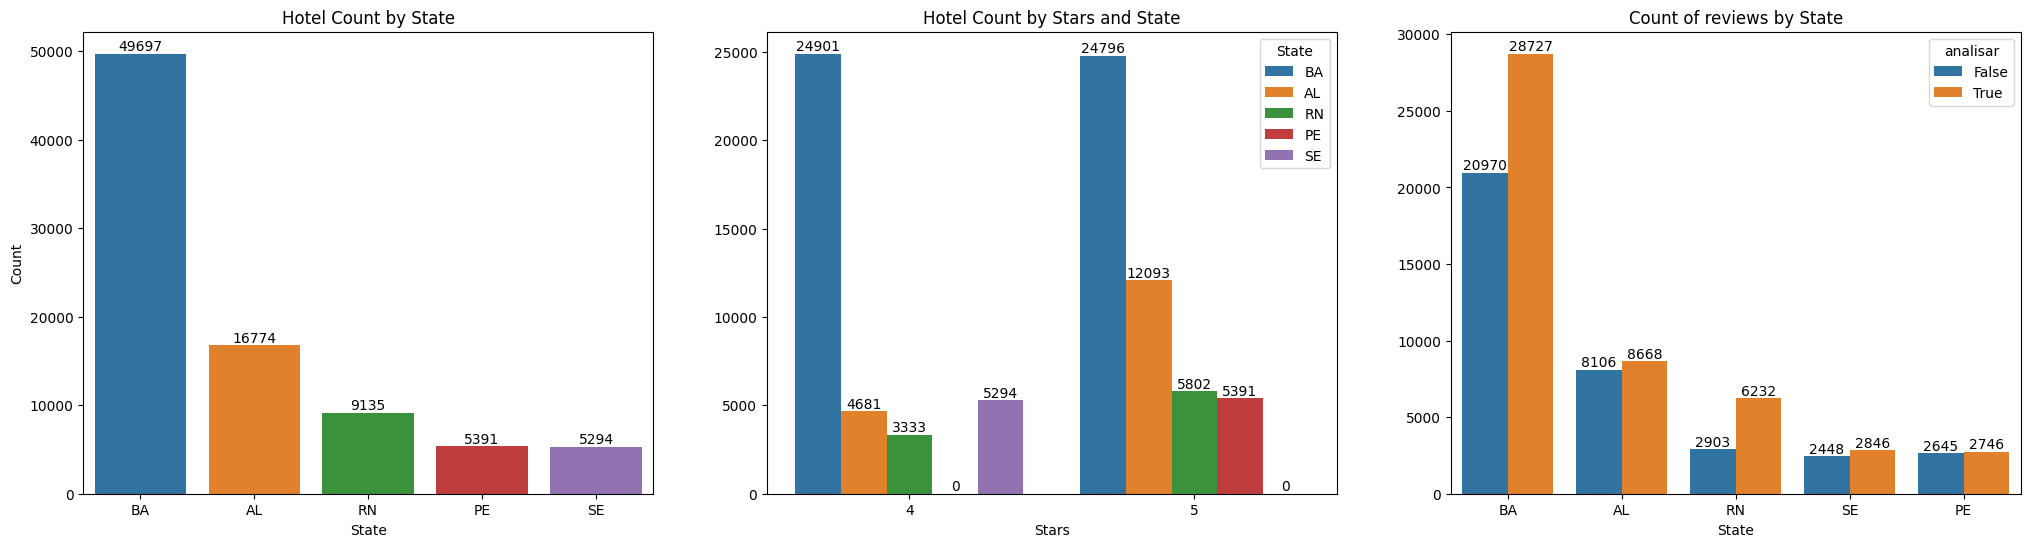

In [331]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
state_counts = hotels_reviews.groupby(['state', 'analisar'])['counts'].sum().reset_index().sort_values('counts', ascending=False)

g = sns.barplot(data=state_counts, x='state', hue='analisar', y='counts', ax=axes[2])
axes[2].set_title('Count of reviews by State')
axes[2].set_xlabel('State')
axes[2].set_ylabel('')

sns.countplot(data=hotels_metadados, x='state', ax=axes[0])
axes[0].set_title('Hotel Count by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')

sns.countplot(data=hotels_metadados, x='stars', hue='state', ax=axes[1])
axes[1].set_title('Hotel Count by Stars and State')
axes[1].set_xlabel('Stars')
axes[1].set_ylabel('')
axes[1].legend(title='State')

for ax in axes.flat:
    # Iterate over each bar in the subplot
    for p in ax.patches:
        # Get the count value of the bar
        count = p.get_height()
        # Add the count value as text annotation
        ax.annotate(f'{int(count)}', (p.get_x() + p.get_width() / 2, p.get_height()),
                          ha='center', va='bottom')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plots
plt.show()

Agora estamos considerando apenas avaliações que serão utilizadas na analise, podemos observar a sua evolução em quantidade númerica durante o tempo, podendo notar uma quebra de tendência no crescimento pós 2019, nos anos de 2020 e 2021, provavelmente causado pelo confinamento decorrente da COVID-21 (referências?) e pós flexibilização do confinamento visualizamos um aumento no número de avaliações, levando em consideração que temos apenas 6 meses de avaliação em 2023 então possivelmente seguiremos com a tendencia de aumento de número de avaliações ano após ano.

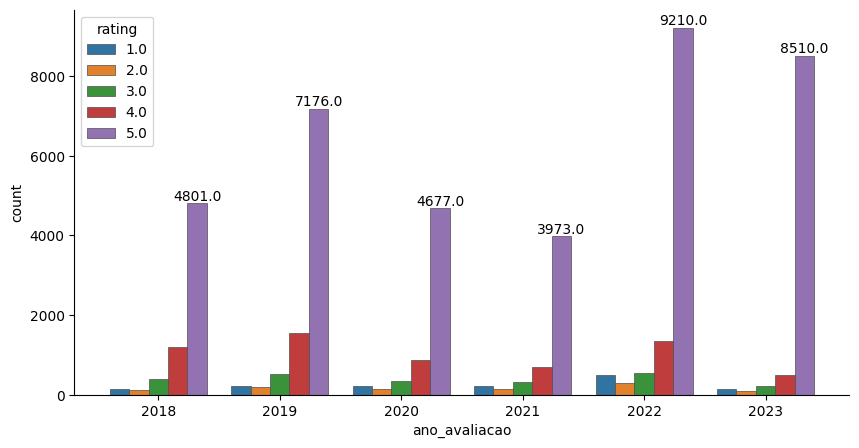

In [333]:
f, _ = plt.subplots(figsize=(10, 5))

sns.despine(f)

g = sns.countplot(
    x="ano_avaliacao",
    hue="rating",
    data=analisar_df,
    edgecolor=".3",
    linewidth=.5,
)
ax = plt.gca()
# Add count values on top of each bar
for p in ax.patches:
  # Get the count value of the bar
  count = p.get_height()
  if (count > 2000):
    # Add the count value as text annotation
    ax.annotate(count,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 5), textcoords='offset points')

ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.autoscale()
plt.show()

#### continuar

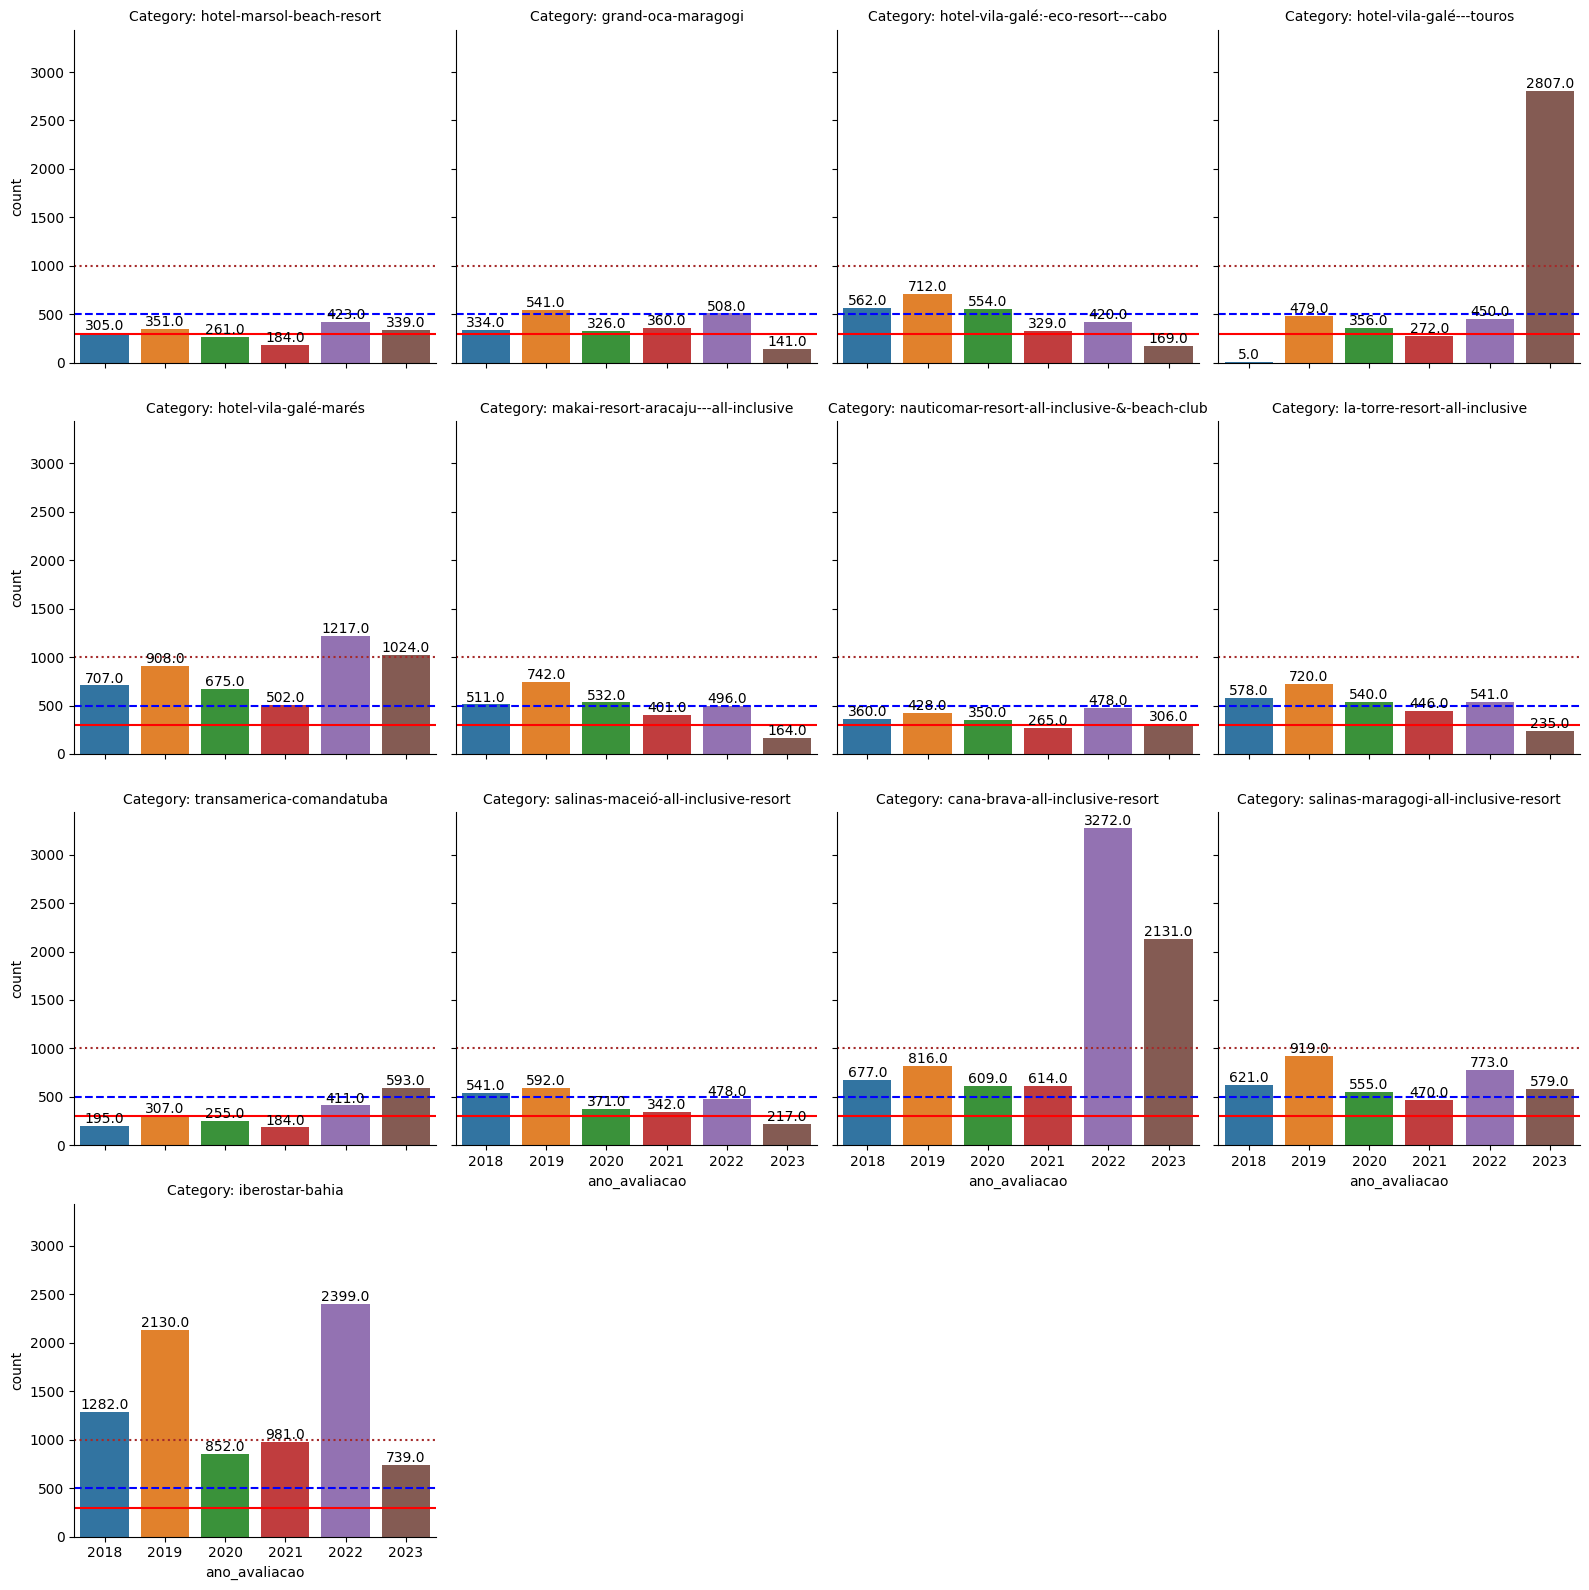

In [337]:
# Create countplot with subplots
g = sns.catplot(
    x="ano_avaliacao",
    col="source",
    data=analisar_df,
    col_wrap=4,
    kind='count',
    height=4,
    aspect=1,
)

# Iterate over each subplot
for ax in g.axes.flat:
    # Iterate over each bar in the subplot
    for p in ax.patches:
        # Get the count value of the bar
        count = p.get_height()
        # Add the count value as text annotation
        ax.annotate(count,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 5), textcoords='offset points')
    ax.axhline(y=300, color='red', linestyle='-')
    ax.axhline(y=500, color='blue', linestyle='--')
    ax.axhline(y=1000, color='brown', linestyle=':')

# Set titles for each subplot
g.set_titles("Category: {col_name}")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## TODO remover esses abaixo
### V
# grand-palladium-imbassaí-resort-&-spa 18/19/20/21
# hotel-coroa-vermelha-beach-all-inclusive 18 / 19 / 20
# iberostar-selection-praia-do-forte 18
# sauípe-premium-brisa---all-inclusive 18/19/20

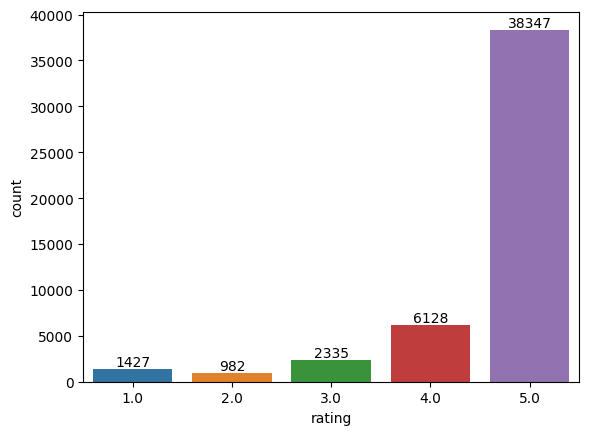

In [338]:
sns.countplot(x="rating", data=analisar_df)
ax = plt.gca()
# Add count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
plt.show()

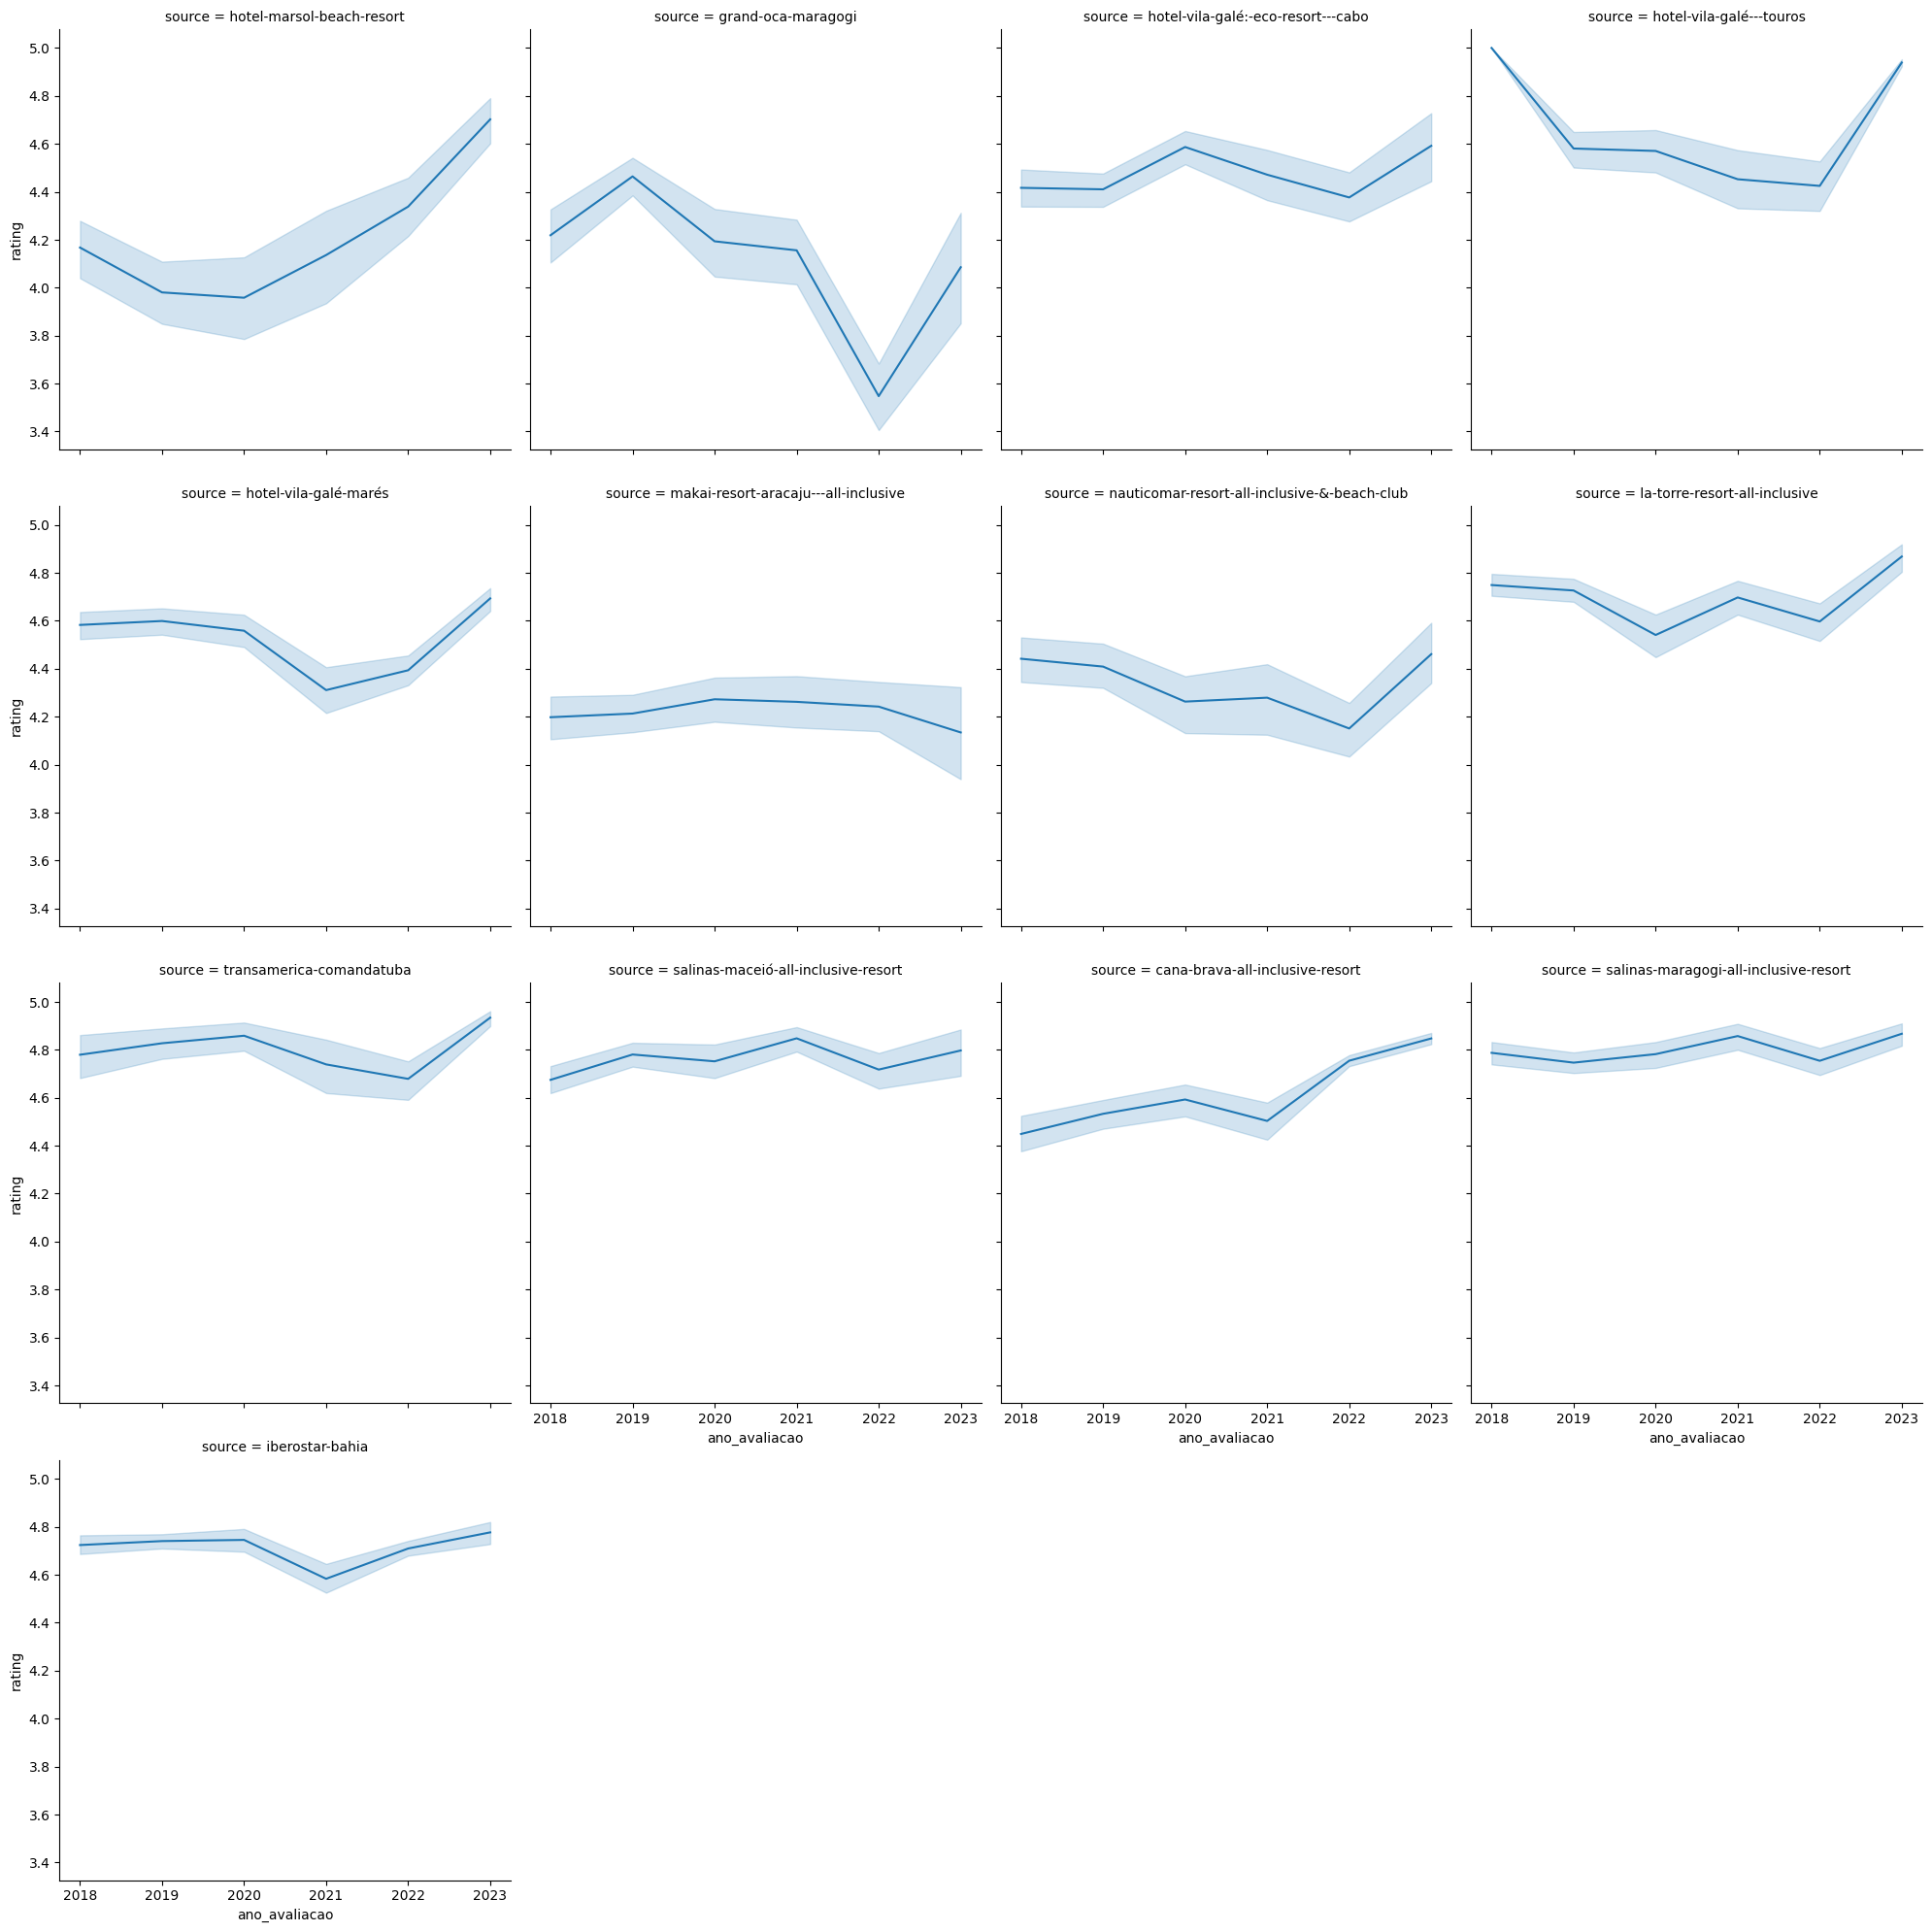

In [339]:
sns.relplot(
    x='ano_avaliacao',
    y='rating',
    col='source',
    kind="line",
    col_wrap=4,
    data=analisar_df,
)
plt.show()

In [340]:
analisar_df[['rating', 'text', 'data_avaliacao', 'user_is_local_guide', 'user_reviews']].head()

,rating,text,data_avaliacao,user_is_local_guide,user_reviews
2,5.0,"Lugar fantástico, recomendo super.",2023-07-06,False,9
5,5.0,Tudo perfeito,2023-07-06,True,36
16,5.0,excelente!,2023-07-06,True,52
17,5.0,Belo lugar.,2023-07-06,True,41
19,5.0,Ótimo local,2023-07-06,False,7


<Figure size 1000x500 with 0 Axes>

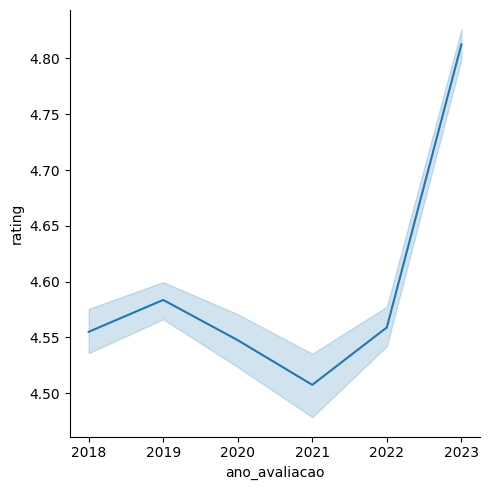

In [341]:
plt.figure(figsize=(10,5))
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=analisar_df)

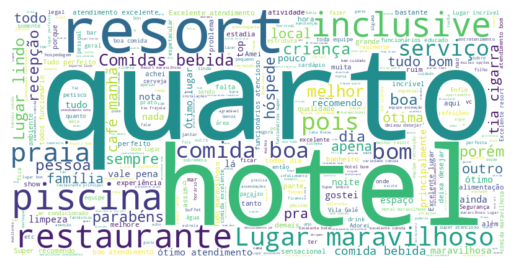

In [343]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

# Concatenar todos os textos em uma única string
texto = ' '.join(analisar_df['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)

# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar um objeto WordCloud com as configurações desejadas
wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)

# Gerar a nuvem de palavras
nuvem = wc.generate(texto_sem_stopwords)

# Exibir a nuvem de palavras
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()

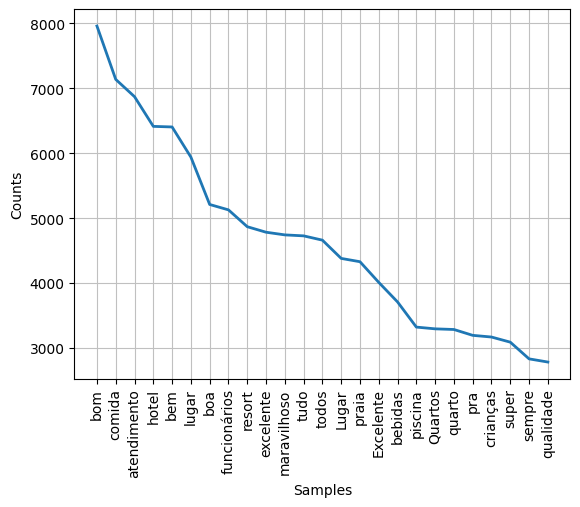

<Axes: xlabel='Samples', ylabel='Counts'>

In [344]:
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

contagem.plot(25)

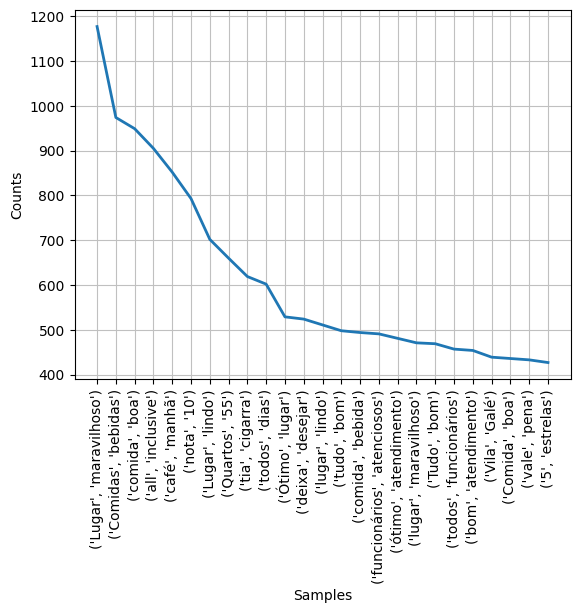

<Axes: xlabel='Samples', ylabel='Counts'>

In [345]:
#Create your bigrams
bgs = nltk.bigrams(palavras)

#compute frequency distribution for all the bigrams in the text
fdist = FreqDist(bgs)
fdist.plot(25)

In [346]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2018
filter = (analisar_df['source']  == 'grand-oca-maragogi') & (analisar_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(analisar_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2018= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2018['year'] = 2018
p2018

,word,frequency,year
0,Adorei,2,2018
1,Lugar,44,2018
2,bonito,9,2018
3,lazer,4,2018
4,fantástico,6,2018
...,...,...,...
1898,letra,1,2018
1899,FRACO,1,2018
1900,julho,1,2018
1901,2017,1,2018


In [347]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2019
filter = (analisar_df['source']  == 'grand-oca-maragogi') & (analisar_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(analisar_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2019= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2019['year'] = ano
p2019

,word,frequency,year
0,Resort,40,2019
1,lindíssimo,2,2019
2,natureza,5,2019
3,exuberante,2,2019
4,praia,132,2019
...,...,...,...
2836,perguntas,1,2019
2837,Haa,1,2019
2838,médico,1,2019
2839,assistência,1,2019


In [348]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2020
filter = (analisar_df['source']  == 'grand-oca-maragogi') & (analisar_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(analisar_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2020= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2020['year'] = ano
p2020

,word,frequency,year
0,deixou,3,2020
1,desejar,16,2020
2,vários,3,2020
3,itens,2,2020
4,grande,8,2020
...,...,...,...
2478,Comi,1,2020
2479,50,1,2020
2480,fikei,1,2020
2481,gastei,1,2020


In [349]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2021
filter = (analisar_df['source']  == 'grand-oca-maragogi') & (analisar_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(analisar_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2021= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2021['year'] = ano
p2021

,word,frequency,year
0,Pode,2,2021
1,melhor,34,2021
2,atendimento,64,2021
3,comida,84,2021
4,drinks,14,2021
...,...,...,...
2718,repetia,1,2021
2719,Suco,1,2021
2720,tematico,1,2021
2721,topso,1,2021


In [350]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2022
filter = (analisar_df['source']  == 'grand-oca-maragogi') & (analisar_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(analisar_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2022= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2022['year'] = ano
p2022

,word,frequency,year
0,resort,138,2022
1,bonito,25,2022
2,infraestrutura,6,2022
3,boa,93,2022
4,tanto,26,2022
...,...,...,...
5056,corrermos,1,2022
5057,Sistema,1,2022
5058,mudarem,1,2022
5059,Magnífica,1,2022


In [351]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
ano = 2023
filter = (analisar_df['source']  == 'grand-oca-maragogi') & (analisar_df['ano_avaliacao'] == ano)
# Concatenar todos os textos em uma única string
texto = ' '.join(analisar_df[filter]['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)
#
# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))
#
# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

p2023= pd.DataFrame(contagem.items(), columns=['word', 'frequency'])
p2023['year'] = ano
p2023

,word,frequency,year
0,PONTOS,1,2023
1,NEGATIVOS,1,2023
2,1º,1,2023
3,local,17,2023
4,praiano,1,2023
...,...,...,...
2406,absurdamente,1,2023
2407,caros,1,2023
2408,sim,1,2023
2409,pro,1,2023


In [352]:
pd.concat([p2018, p2019,p2020,p2021,p2022, p2023]).sort_values(by=['frequency', 'year'], ascending=[False, False])

,word,frequency,year
8,praia,206,2022
56,comida,186,2022
53,bem,140,2022
0,resort,138,2022
83,hotel,136,2022
...,...,...,...
1898,letra,1,2018
1899,FRACO,1,2018
1900,julho,1,2018
1901,2017,1,2018


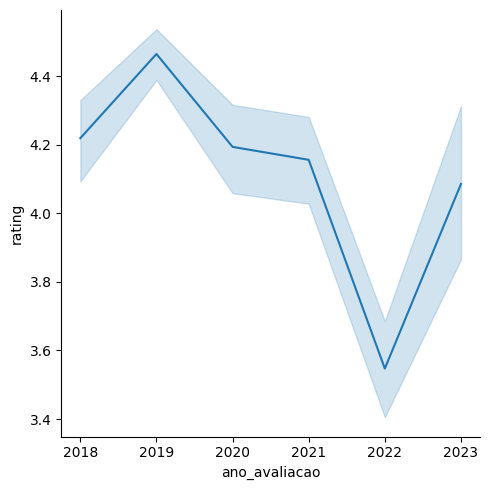

In [353]:
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=analisar_df[analisar_df['source']  == 'grand-oca-maragogi'])


# bert

https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

https://sol.sbc.org.br/index.php/stil/article/view/17784

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [ ]:
!nvidia-smi

In [ ]:
!pip install -qq transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, pipeline

In [ ]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
nlp = pipeline("sentense-classification", model=model, tokenizer=tokenizer)

In [ ]:
nlp("Olá, meu cachorro ÉUMDeus")

In [ ]:
classifications = [model.config.id2label[output] for output in [1,0]]
print(classifications)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

input_ids = tokenizer("Olá, meu cachorro é uma gracinha", add_special_tokens=True)  # Batch size 1
outputs = model(input_ids).logits

classifications = np.argmax(outputs, axis=1)
print(classifications)

In [ ]:
classifications = [model.config.id2label[output] for output in classifications]
print(classifications)

In [ ]:
logits

In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BertForTokenClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)

input_ids = torch.tensor(tokenizer.encode("Olá, meu cachorro é uma gracinha", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
labels = torch.tensor([1] * input_ids.size(1)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids, labels=labels)

logits = outputs.logits

In [ ]:
def to_sentiment(rating):
  rating = float(rating)
  if rating < 3:
    return 0
  elif rating > 4:
    return 2
  else:
    return 1

df['sentiment'] = df.rating.apply(to_sentiment)
df.head()

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
ax= sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
%mkdir -p gdrive/MyDrive/tcc/bert
file_csv_data = 'gdrive/MyDrive/tcc/bert/reviews.csv'
df.to_csv(file_csv_data, index=None, header=True)

In [ ]:
sample_txt = df.loc[1]['text']
sample_txt

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=45,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

In [ ]:
# deprecated sns.distplot(token_lens)
sns.histplot(token_lens,
             kde=True,
             stat="density",
             kde_kws=dict(cut=3),
             alpha=.4,
             edgecolor=(1, 1, 1, .4),
             )
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [ ]:
max(token_lens)

In [ ]:
MAX_LEN = 512

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
len(train_data_loader)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
class SentimentClassifier(torch.nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = torch.nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


In [ ]:
history

In [ ]:
history['train_acc']

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))


In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# 08

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
from transformers import pipeline

model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
classifier = pipeline('sentiment-analysis', model=model_path, tokenizer=model_path)

In [ ]:
filtered_df['sentiment'] = filtered_df['text'].apply(lambda x: classifier(x).label)

In [ ]:

sentences = [
  "Gostei muito do vídeo!",
  "Não estou feliz com os resultados."
]

result = classifier("Gostei muito do vídeo!")

In [ ]:
result